In [386]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import heapq
import imageio

In [387]:
size = (30, 50)
# obstacles = [(5, 5, 10,10), (20, 30, 25, 45), (15, 0, 20, 5), (15, 17, 20, 22)]
obstacles = [(5, 5, 10, 15), (20, 5, 25, 15), (5, 30, 10, 40), (20, 30, 25, 40), (3, 20, 12, 25), (18, 20, 27, 25)]
start = (0, 0)
# goal = (29, 40)
goal = (29, 35)

In [388]:
class Node:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.parent_node = None

In [389]:
def is_within_obstacles(point, obstacles):
  for (x1, y1, x2, y2) in obstacles:
    if x1<=point[0]<=x2 and y1<=point[1]<=y2:
      return True
  return False

def distance(point1, point2):
  return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def nearest_node(nodes, random_point):
  return min(nodes, key=lambda node: distance((node.x, node.y), random_point))

def steer(from_node, to_point, step_size=1):
  if distance((from_node.x, from_node.y), to_point)<step_size:
    return Node(to_point[0], to_point[1])
  else:
    theta = np.arctan2(to_point[1]-from_node.y, to_point[0]-from_node.x)
    return Node(from_node.x + step_size*np.cos(theta), from_node.y + step_size*np.sin(theta))

""" Check if the path between node1 and node2 is valid by interpolating points along the way. """
def is_valid_path(node1, node2, obstacles):
  steps = int(distance((node1.x, node1.y), (node2.x, node2.y))/0.5)  # Smaller steps for more accuracy

  for i in range(1, steps + 1):
    inter_x = node1.x + i*(node2.x-node1.x)/steps
    inter_y = node1.y + i*(node2.y-node1.y)/steps

    if is_within_obstacles((inter_x, inter_y), obstacles):
      return False
  return True


def plot(nodes=None, path=None):
    fig, ax = plt.subplots()
    if nodes:
      for node in nodes:
          if node.parent_node:
              plt.plot([node.x, node.parent_node.x], [node.y, node.parent_node.y], "g-", linewidth=0.5)
    for (ox, oy, ex, ey) in obstacles:
        ax.add_patch(plt.Rectangle((ox, oy), ex-ox, ey-oy, color="red"))
    if path:
        plt.plot([node.x for node in path], [node.y for node in path], "b-", linewidth=2)  # Highlight path in blue
    plt.plot(start[0], start[1], "bo")  # Start
    plt.plot(goal[0], goal[1], "ro")  # Goal
    plt.grid(True)
    plt.show()

In [390]:
def rrt(step_size=1, max_nodes=10000):
    nodes = [Node(start[0], start[1])]
    while len(nodes) < max_nodes:
        random_point = (random.randint(0, size[0] - 1), random.randint(0, size[1] - 1))
        if is_within_obstacles(random_point, obstacles):
            continue
        nearest = nearest_node(nodes, random_point)
        new_node = steer(nearest, random_point, step_size)
        if not is_within_obstacles((new_node.x, new_node.y), obstacles) and is_valid_path(nearest, new_node, obstacles):
            new_node.parent_node = nearest
            nodes.append(new_node)
            if distance((new_node.x, new_node.y), goal) <= 2:#step_size:
                return nodes, new_node
    return nodes, None  # Return None if max_nodes reached without finding a path

In [391]:
def fitness_function(path):
    coordinates = [(node.x, node.y) for node in path]
    w1 = 3
    w2 = 1
    euc_dist = 0
    angle_sum = 0
    for i in range(len(coordinates)-1):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i+1]
        dist_ = math.sqrt((x2-x1)**2 +(y2-y1)**2)
        euc_dist += dist_
        if i != len(coordinates)-2:
          x3, y3 = coordinates[i+2]
          heading1 = math.degrees(math.atan2((y2-y1),(x2-x1)))
          heading2 = math.degrees(math.atan2((y3-y2),(x3-x2)))
          if heading1 < 0:
            heading1 = 360 + heading1
          if heading2 < 0:
            heading2 = 360 + heading2
          angle = abs(heading2-heading1)
          angle_sum += angle

    F = w1*(1/(euc_dist))+ w2*1/(angle_sum)
    return euc_dist, F

In [392]:
def calcualte_fitness_of_population(population):
  fitness = []
  for index, path in enumerate(population):
    euc_dist, F = fitness_function(path)
    fitness.append(F)
  return fitness

In [393]:
def selection(fitness, population):
  P1 = []
  P2 = []
  while(fitness):
    max_fitness = max(fitness)
    index = fitness.index(max_fitness)
    fitness.pop(index)
    P1.append(population.pop(index))

    l = len(fitness)
    i = random.randint(0, l-1)
    fitness.pop(i)
    P2.append(population.pop(i))
  return P1, P2

In [394]:
def best_selection(fitness, population):
  P1 = []
  P2 = []
  while(fitness):
    max_fitness = max(fitness)
    index = fitness.index(max_fitness)
    fitness.pop(index)
    P1.append(population.pop(index))

    max_fitness = max(fitness)
    index = fitness.index(max_fitness)
    fitness.pop(index)
    P2.append(population.pop(index))

  return P1, P2

In [395]:
def plot_best_solution(fitness, population, plot_graph=False):
  max_fitness = max(fitness)
  index = fitness.index(max_fitness)
  best_path = population[index]
  print(f"Fitness: {max_fitness}")
  if plot_graph:
    plot(path=best_path)
  return max_fitness

In [396]:
#CrossOver points
def crossoverpt(parent1,parent2):
    minval=2
    offspring1=[]
    offspring2=[]
    #range defined in such a way that it ignores inital and final points
    for pt1 in range(3, len(parent1)-3):
        for pt2 in range(3, len(parent2)-3):
            #Calculating  distance between every nodes of 2 paths and selecting the min distance path points
            if (math.sqrt((parent1[pt1].x-parent2[pt2].x)**2+(parent1[pt1].y-parent2[pt2].y)**2))<minval:
                # print("DISTANCE: ")
                # print(math.sqrt((parent1[pt1].x-parent2[pt2].x)**2+(parent1[pt1].y-parent2[pt2].y)**2))
                # print("parent1 point: ", parent1[pt1].x, parent1[pt1].y)
                # print("parent2 point: " , parent2[pt2].x, parent2[pt2].y)
                # if (minval>math.sqrt((parent1[1][pt1].x-parent2[1][pt2].x)**2+(parent1[1][pt1].y-parent2[1][pt2].y)**2)):
                minval=math.sqrt((parent1[pt1].x-parent2[pt2].x)**2+(parent1[pt1].y-parent2[pt2].y)**2)
                #storing path points indexes so to use them to crossover
                parent1_point_idx=pt1
                parent2_point_idx=pt2

    # Pruning the path and making crossover based on the indexes calculated
    for i in range(parent1_point_idx+1):
        offspring1.append(Node(parent1[i].x,parent1[i].y))
    for i in range(parent2_point_idx,len(parent2)):
        offspring1.append(Node(parent2[i].x,parent2[i].y))

    for i in range(parent2_point_idx+1):
        offspring2.append(Node(parent2[i].x,parent2[i].y))
    for i in range(parent1_point_idx,len(parent1)):
        offspring2.append(Node(parent1[i].x,parent1[i].y))


    #Returning offsprings
    return offspring1,offspring2

In [397]:
def elimination(fitness, population):
  num_eliminations = 2
  for i in range(0, num_eliminations):
    min_fitness = min(fitness)
    index = fitness.index(min_fitness)
    fitness.pop(index)
    population.pop(index)
  return fitness, population

In [398]:
def create_initial_population(population_size=20, step_size=1, plot_paths = True):
  population = []
  for i in range(population_size):
    nodes, final_node = rrt(step_size=step_size)
    path = []
    if final_node:
        while final_node.parent_node:
            path.append(final_node)
            final_node = final_node.parent_node
        path.append(final_node)
        path.reverse()
    if plot_paths:
      plot(nodes, path)
    population.append(path)
  return population

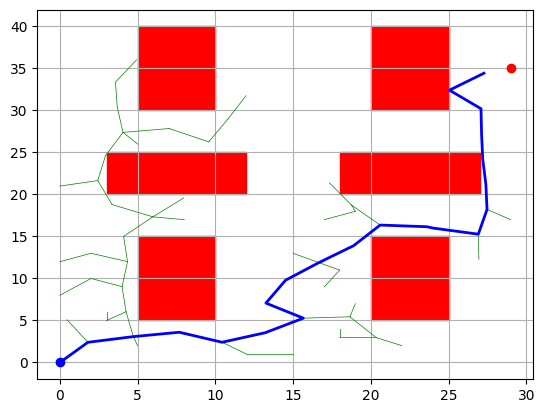

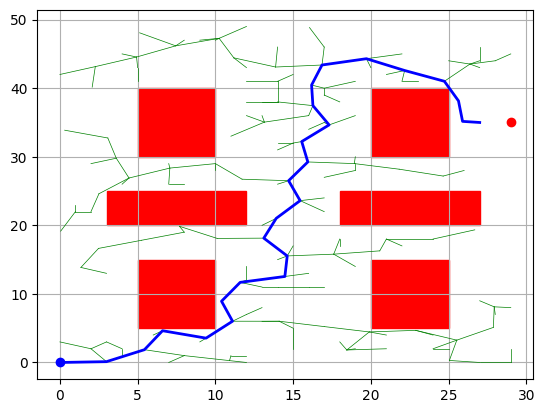

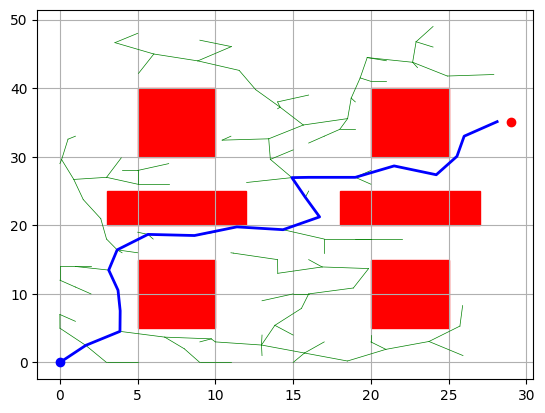

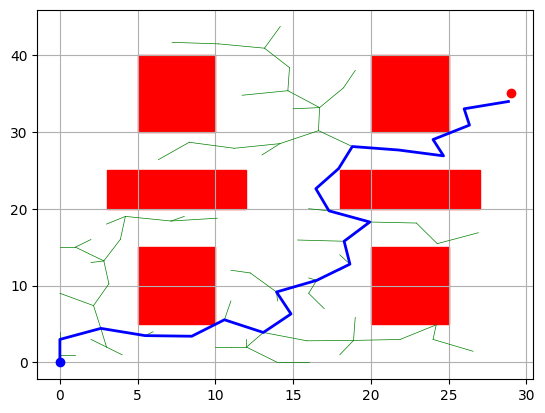

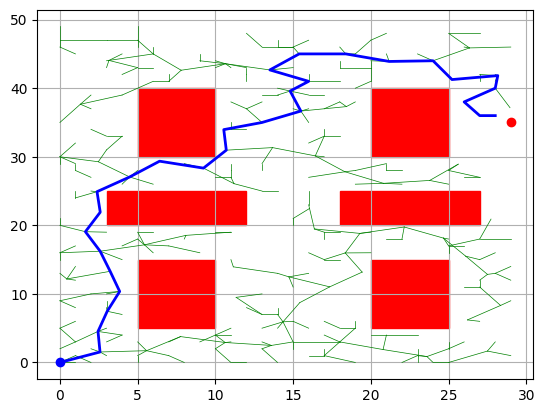

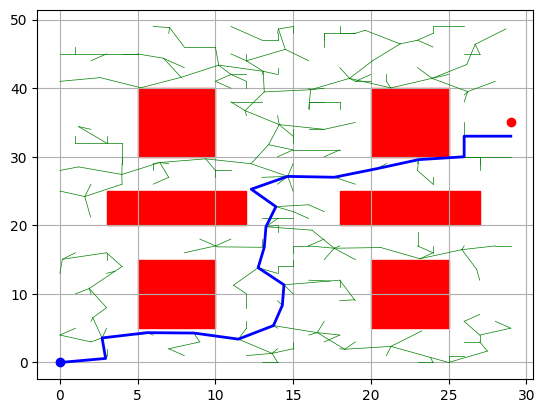

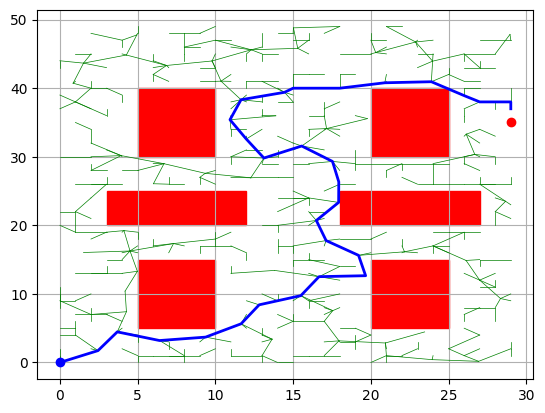

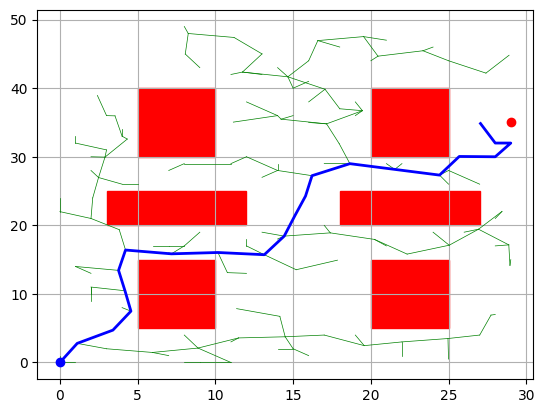

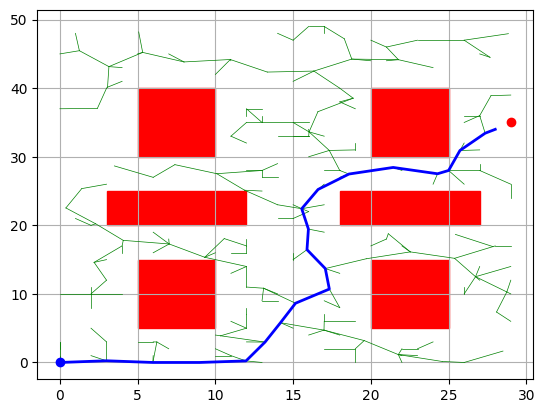

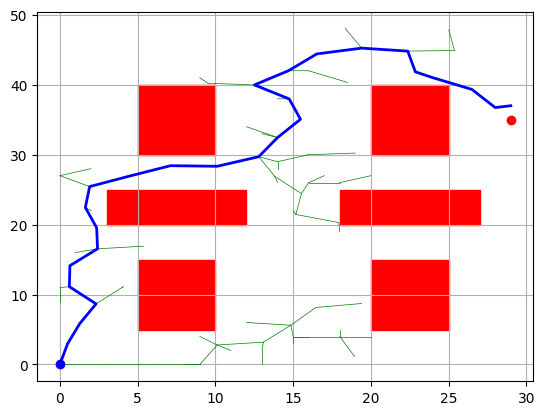

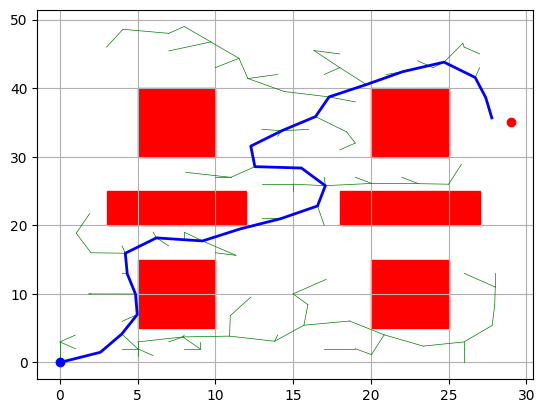

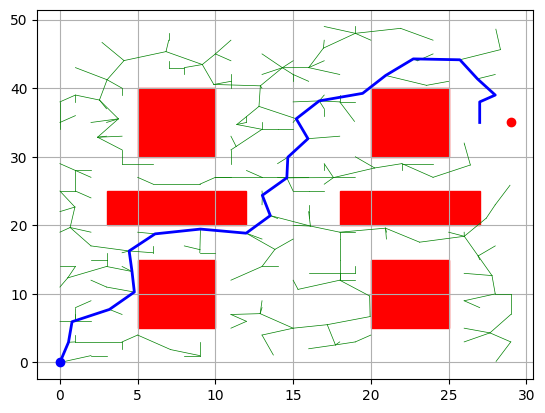

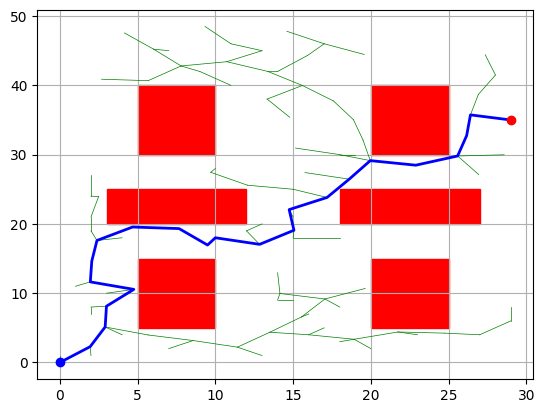

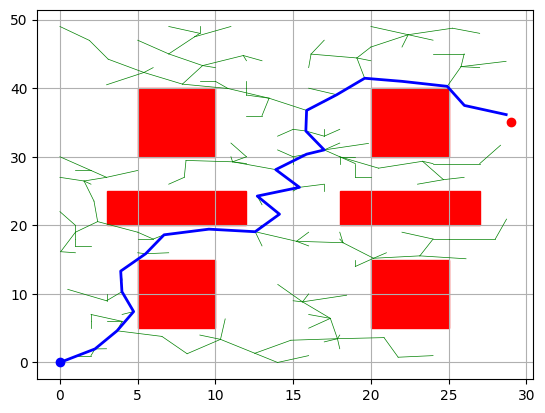

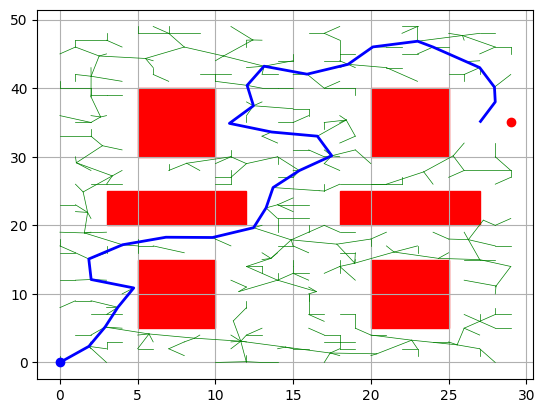

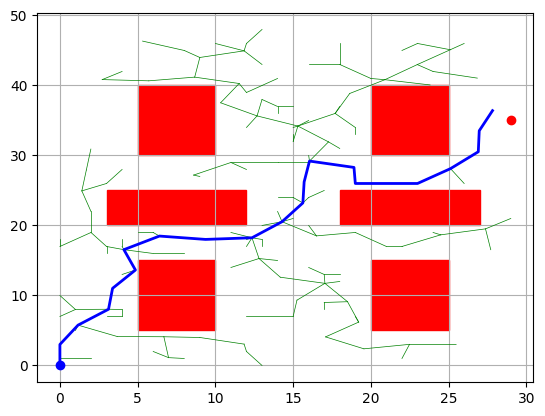

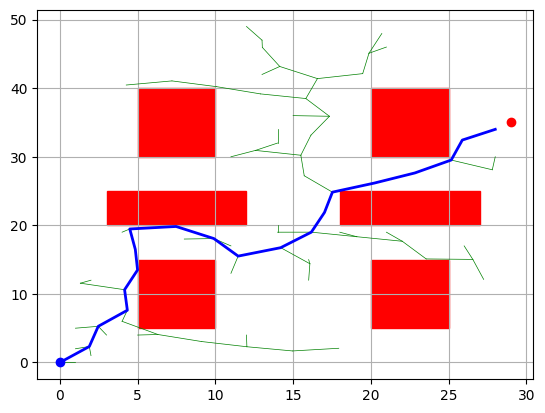

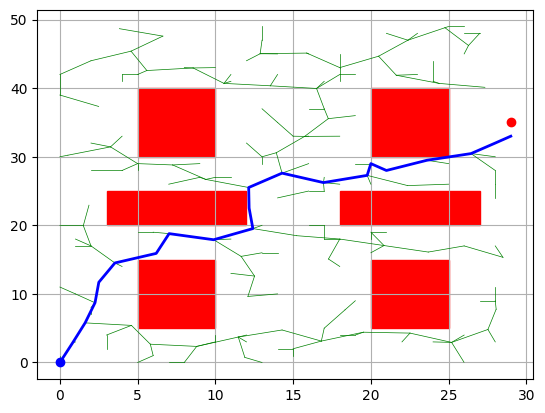

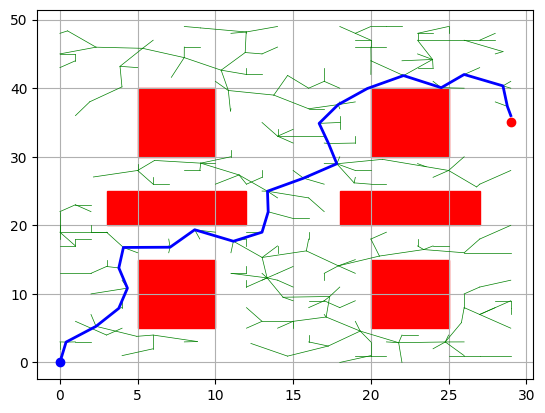

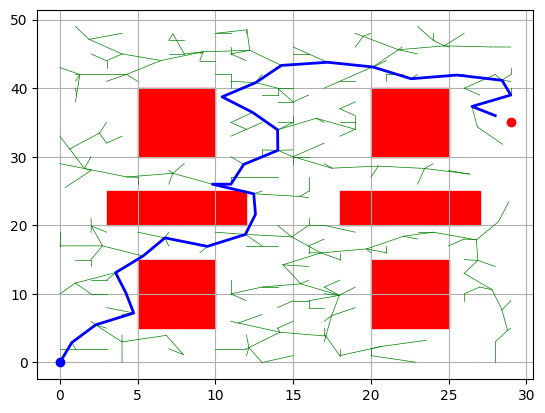

In [399]:
population = create_initial_population(population_size=20, step_size=3, plot_paths=True)

Generation: 1
Fitness: 0.0552921388528349


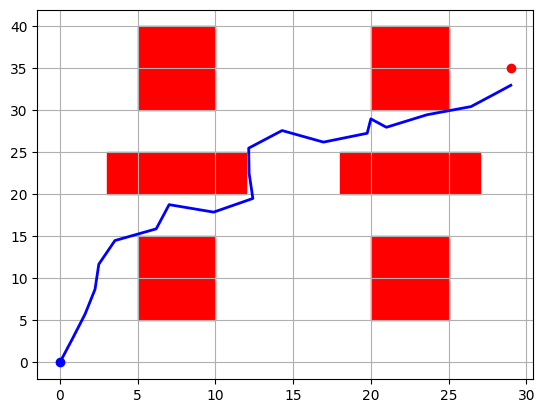

Generation: 2
Fitness: 0.05502669392603105


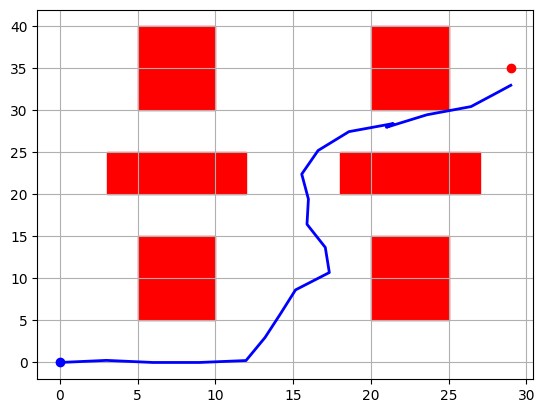

Generation: 3
Fitness: 0.054416970138916686


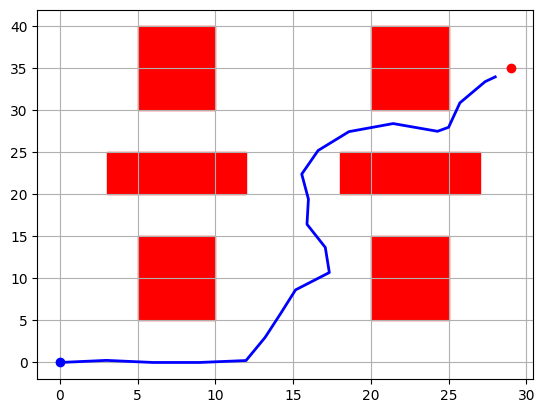

Generation: 4
Fitness: 0.05500886236220778


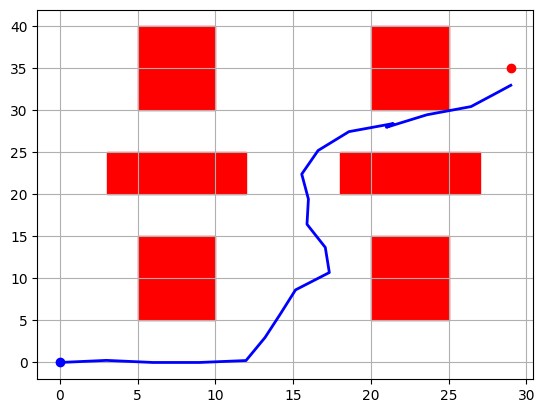

Generation: 5
Fitness: 0.05444579918338138


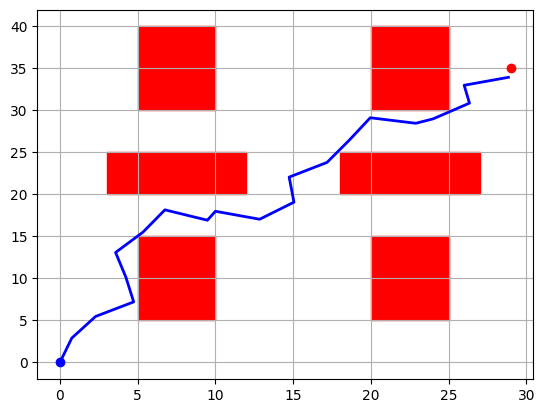

Generation: 6
Fitness: 0.056505828449617435


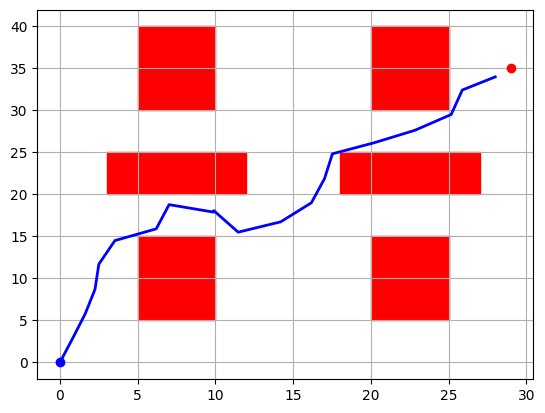

Generation: 7
Fitness: 0.05612307617819713


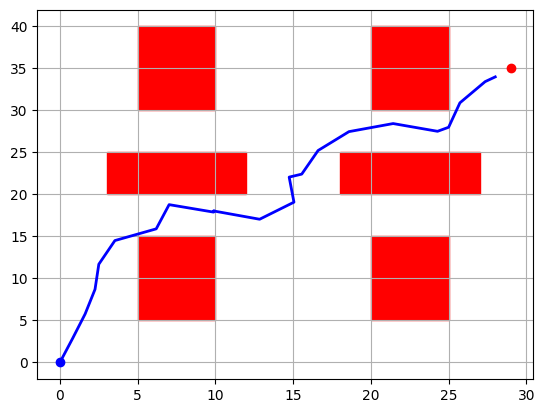

Generation: 8
Fitness: 0.056419773241093756


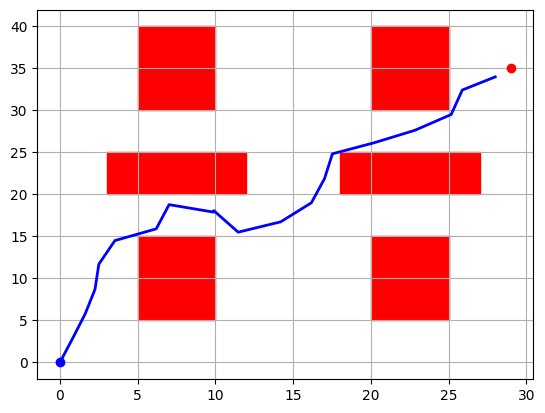

Generation: 9
Fitness: 0.056088883905301014


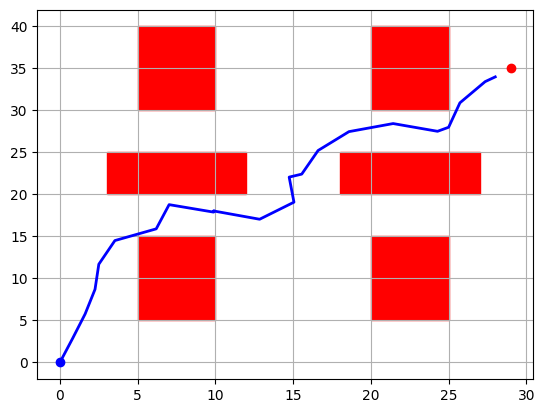

Generation: 10
Fitness: 0.056419773241093756


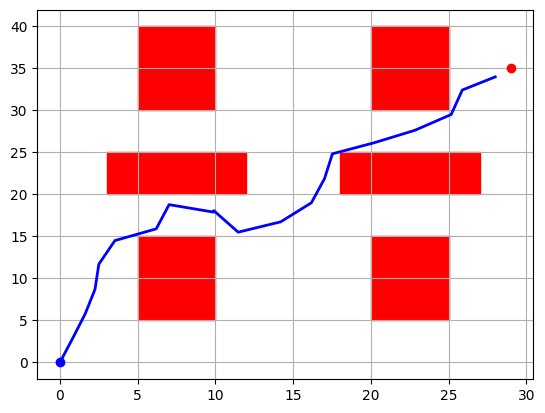

Generation: 11
Fitness: 0.056088883905301014


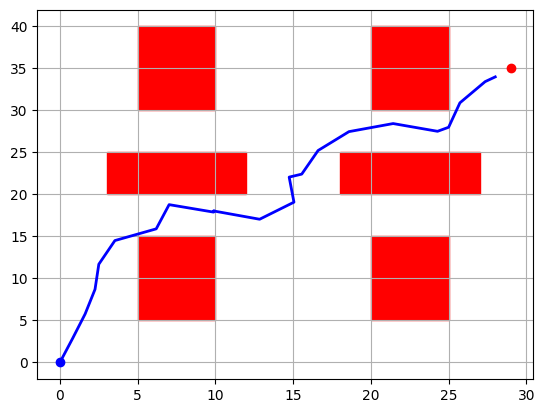

Generation: 12
Fitness: 0.056419773241093756


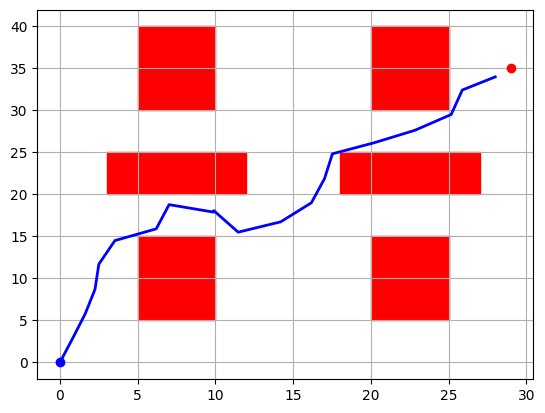

Generation: 13
Fitness: 0.056088883905301014


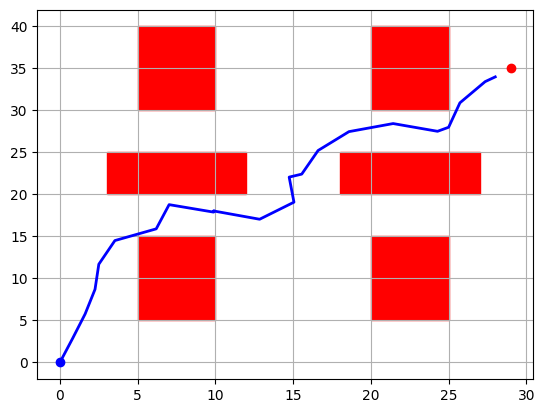

Generation: 14
Fitness: 0.056419773241093756


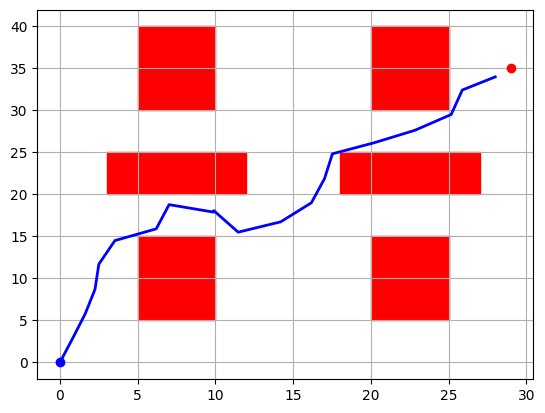

Generation: 15
Fitness: 0.056088883905301014


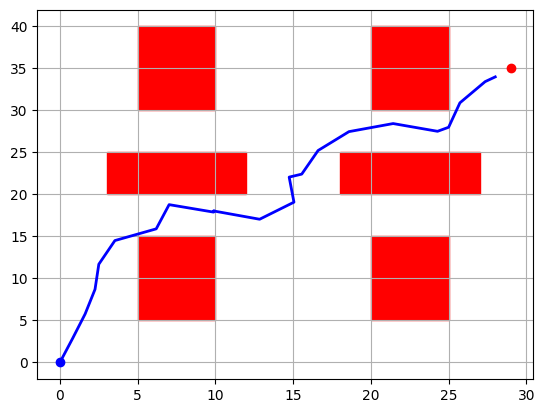

Generation: 16
Fitness: 0.056419773241093756


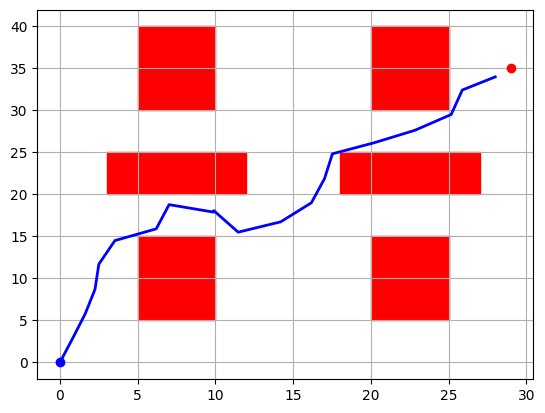

Generation: 17
Fitness: 0.056088883905301014


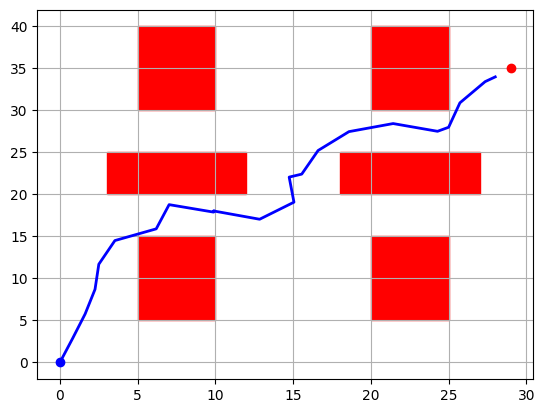

Generation: 18
Fitness: 0.056419773241093756


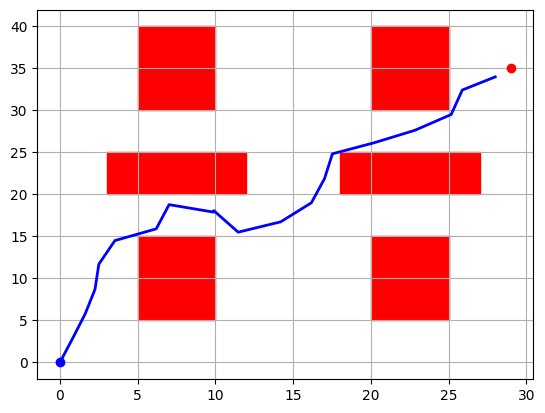

Generation: 19
Fitness: 0.056088883905301014


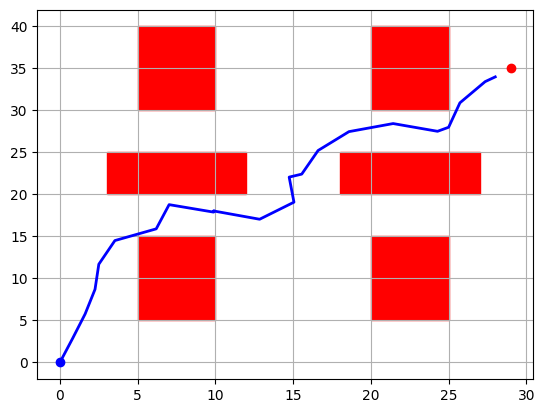

Generation: 20
Fitness: 0.056419773241093756


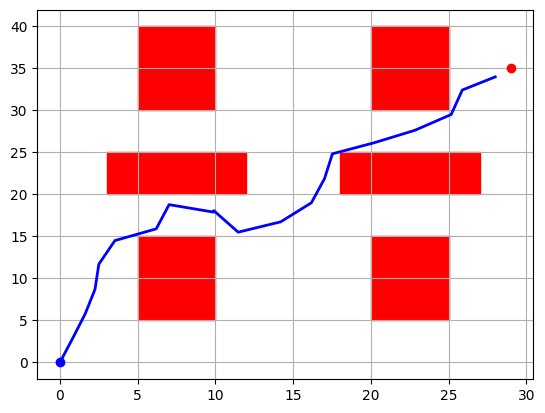

Generation: 21
Fitness: 0.056088883905301014


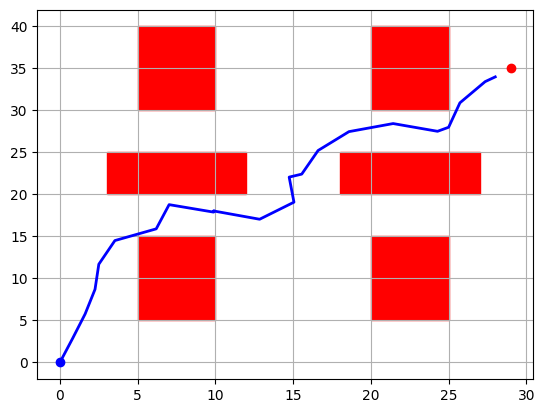

Generation: 22
Fitness: 0.056419773241093756


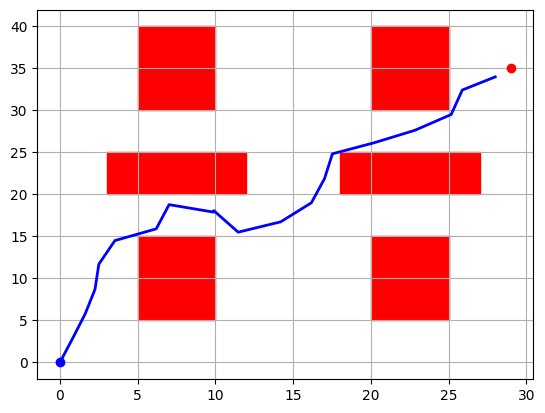

Generation: 23
Fitness: 0.056088883905301014


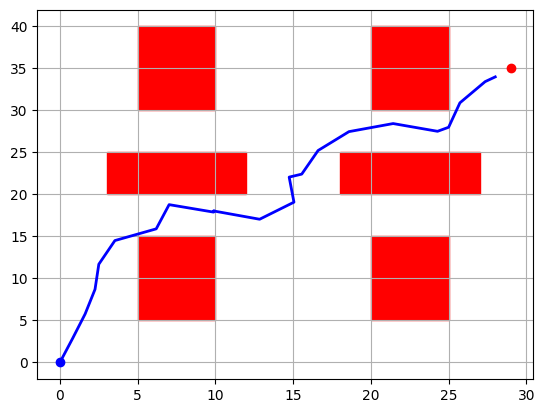

Generation: 24
Fitness: 0.056419773241093756


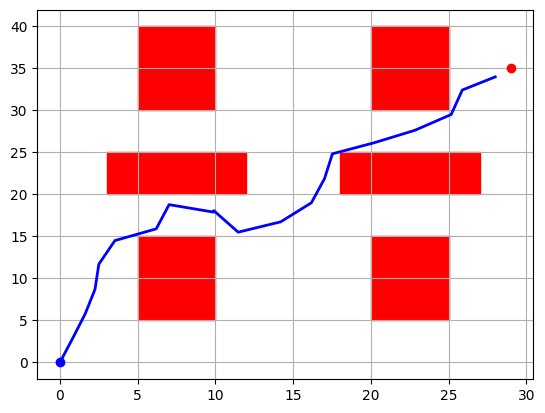

Generation: 25
Fitness: 0.056088883905301014


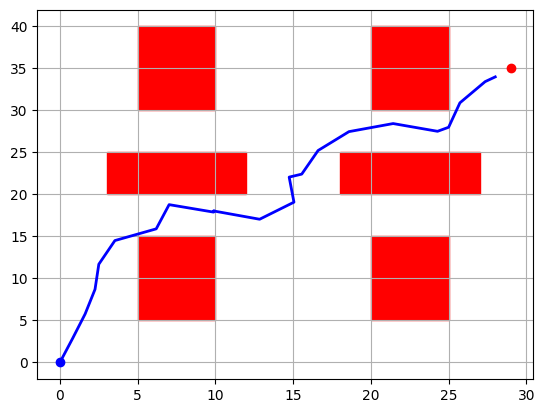

Generation: 26
Fitness: 0.056419773241093756


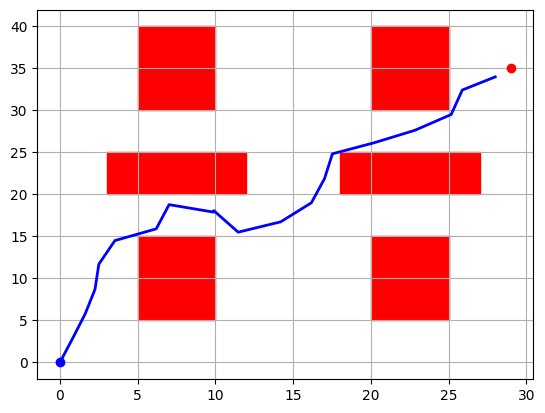

Generation: 27
Fitness: 0.056088883905301014


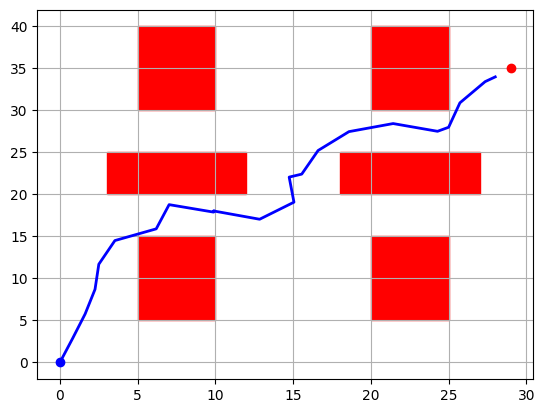

Generation: 28
Fitness: 0.056419773241093756


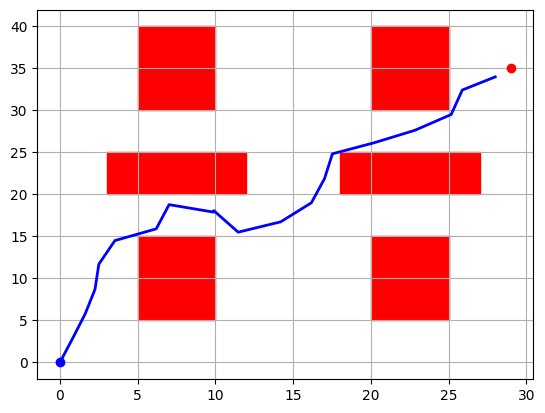

Generation: 29
Fitness: 0.056088883905301014


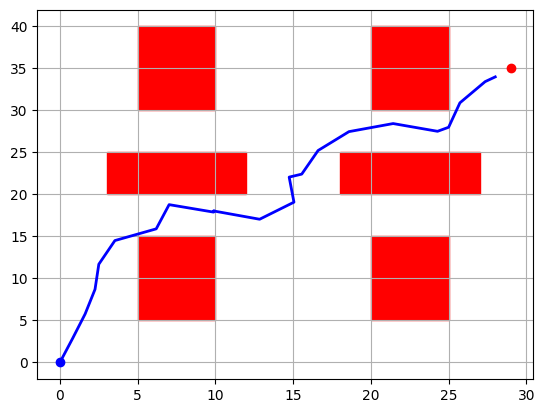

Generation: 30
Fitness: 0.056419773241093756


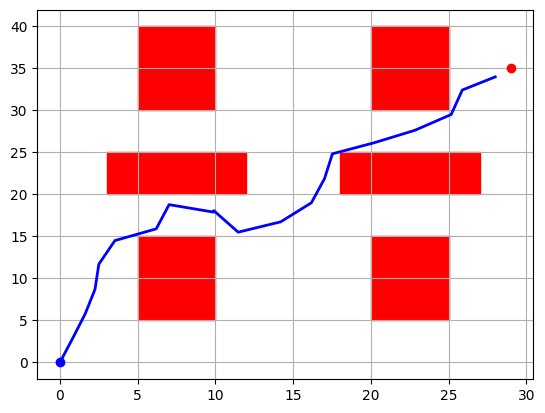

Generation: 31
Fitness: 0.056088883905301014


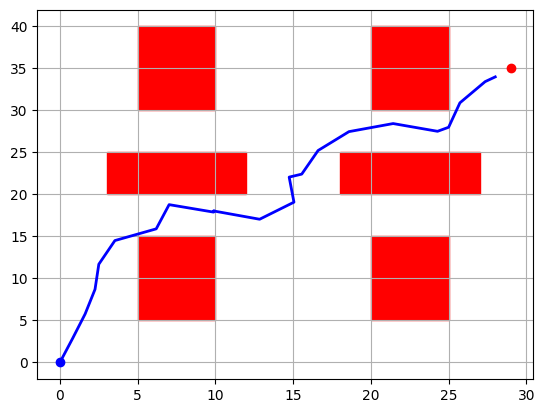

Generation: 32
Fitness: 0.056419773241093756


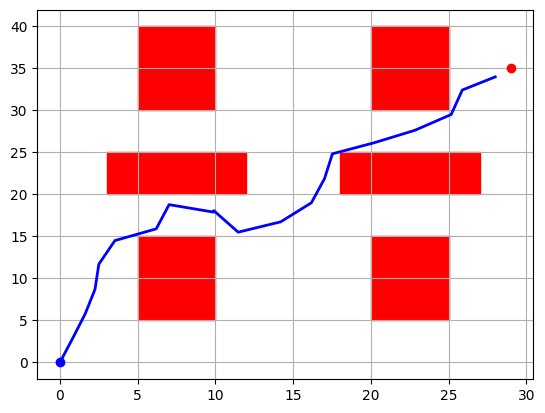

Generation: 33
Fitness: 0.056088883905301014


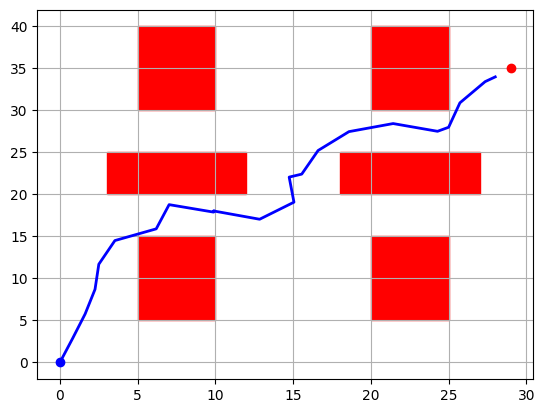

Generation: 34
Fitness: 0.056419773241093756


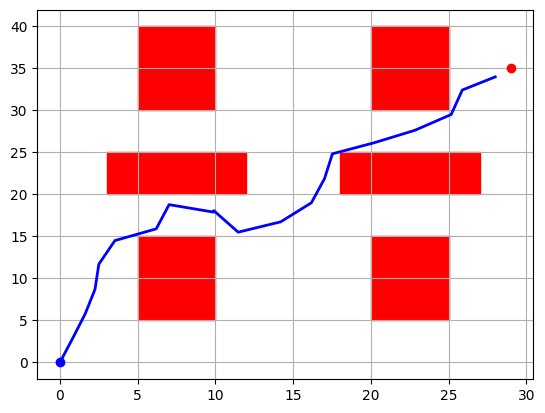

Generation: 35
Fitness: 0.056088883905301014


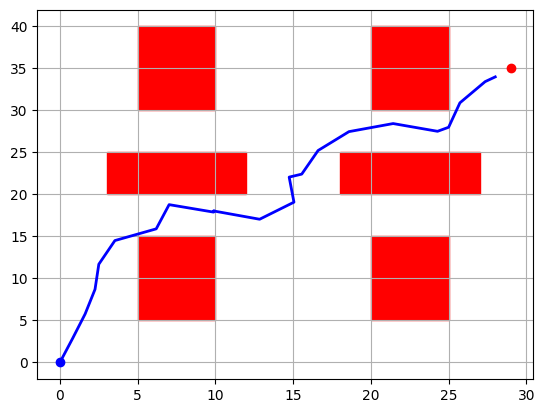

Generation: 36
Fitness: 0.056419773241093756


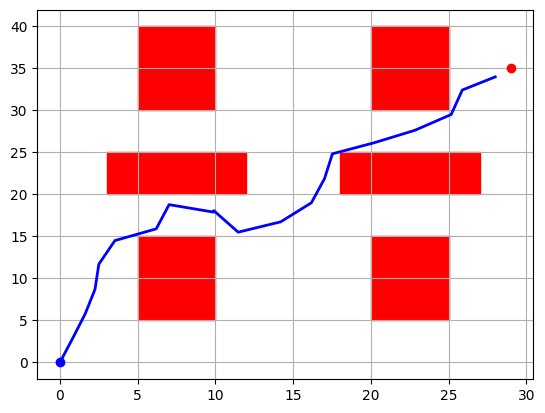

Generation: 37
Fitness: 0.056088883905301014


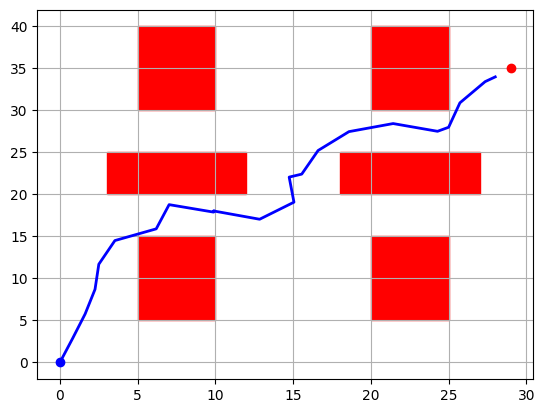

Generation: 38
Fitness: 0.056419773241093756


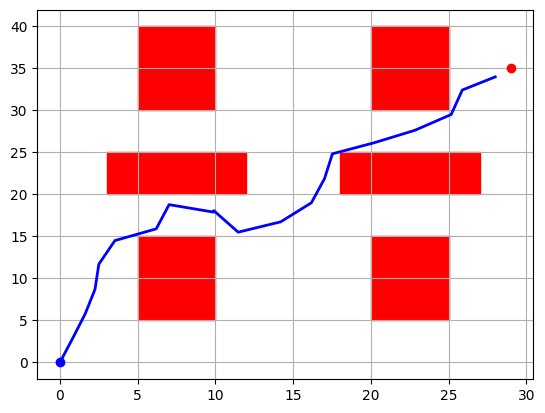

Generation: 39
Fitness: 0.056088883905301014


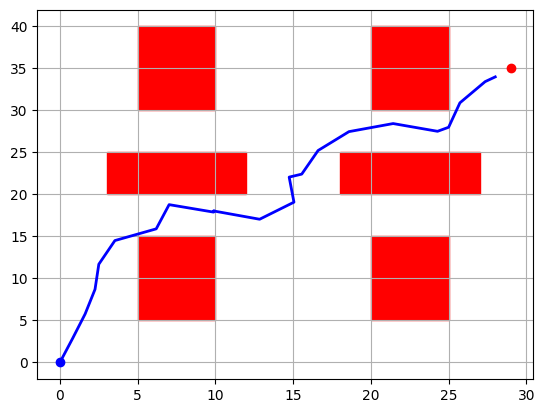

Generation: 40
Fitness: 0.056419773241093756


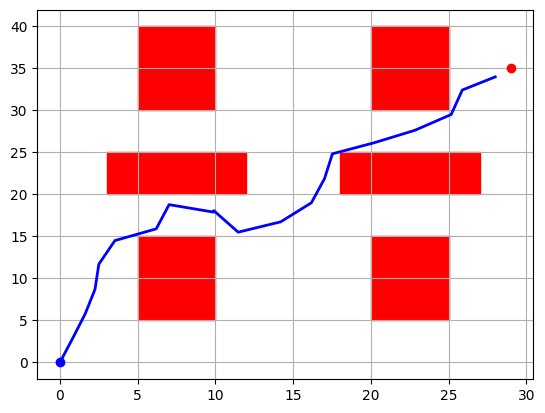

Generation: 41
Fitness: 0.056088883905301014


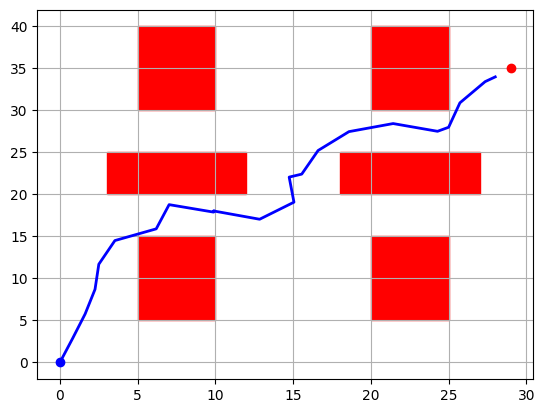

Generation: 42
Fitness: 0.056419773241093756


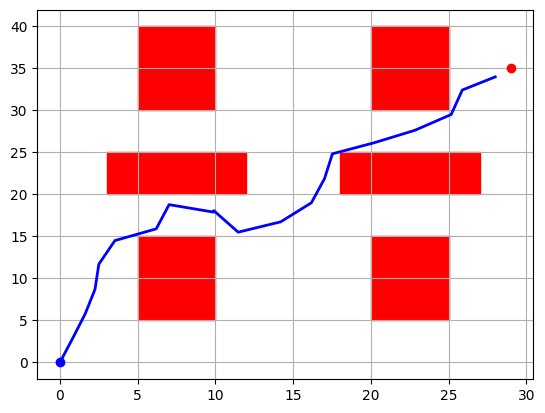

Generation: 43
Fitness: 0.056088883905301014


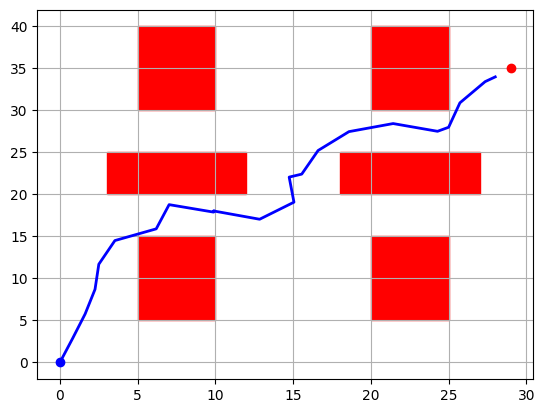

Generation: 44
Fitness: 0.056419773241093756


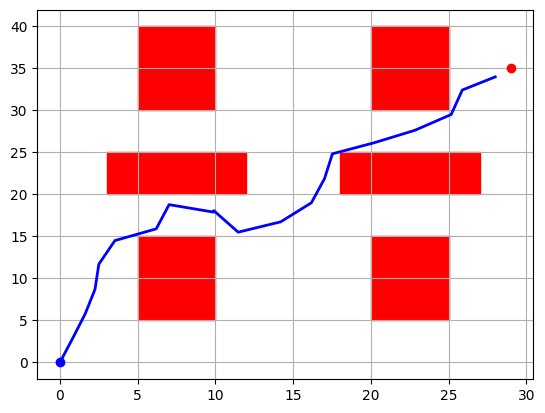

Generation: 45
Fitness: 0.056088883905301014


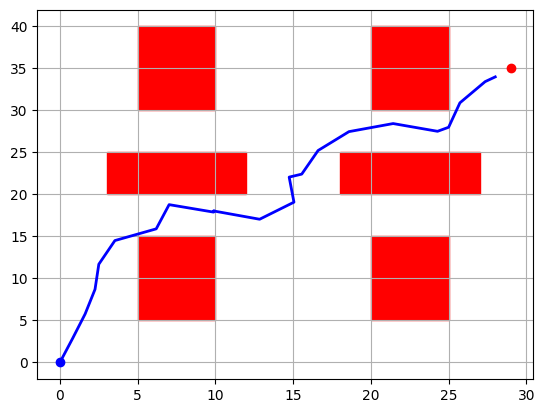

Generation: 46
Fitness: 0.056419773241093756


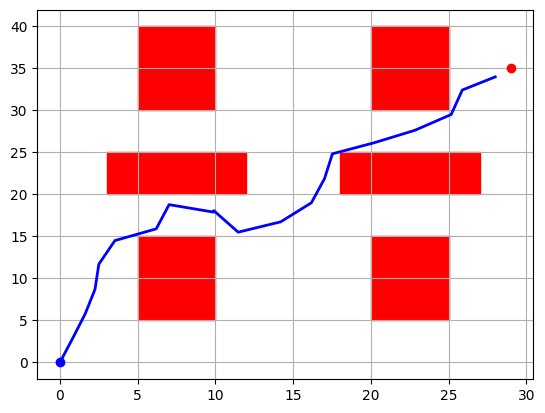

Generation: 47
Fitness: 0.056088883905301014


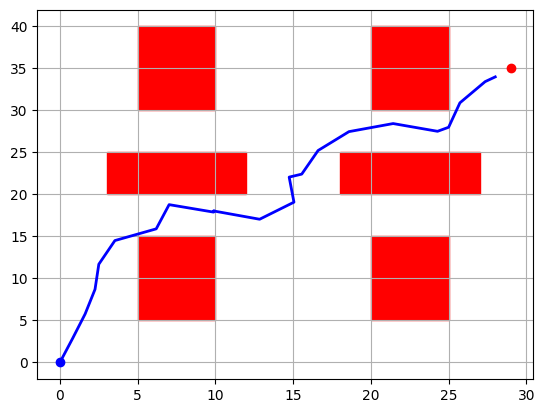

Generation: 48
Fitness: 0.056419773241093756


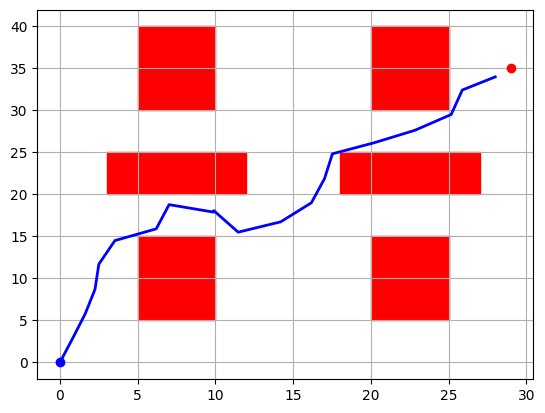

Generation: 49
Fitness: 0.056088883905301014


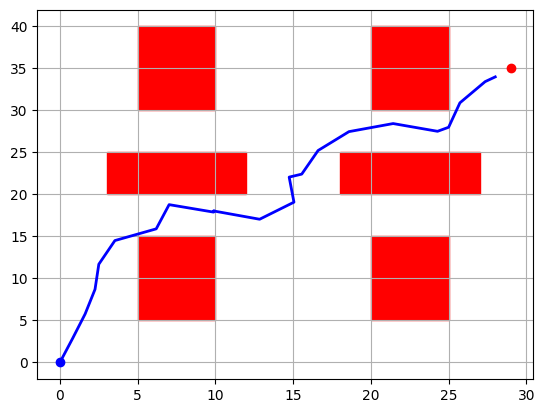

Generation: 50
Fitness: 0.056419773241093756


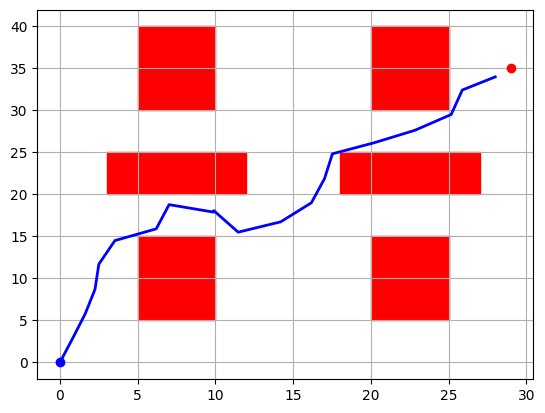

Generation: 51
Fitness: 0.056088883905301014


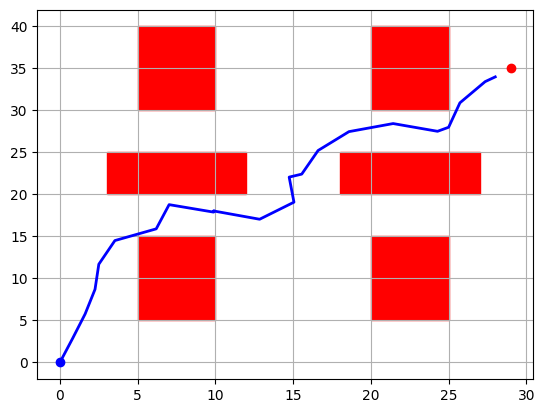

Generation: 52
Fitness: 0.056419773241093756


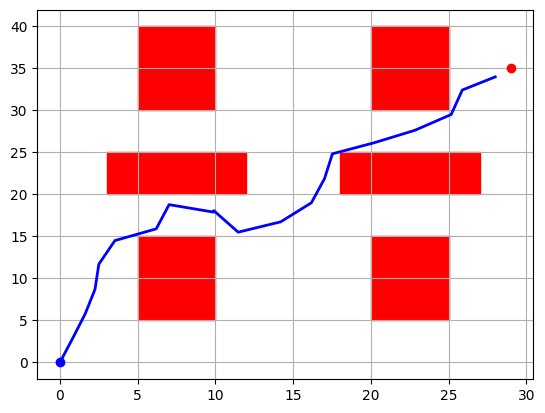

Generation: 53
Fitness: 0.056088883905301014


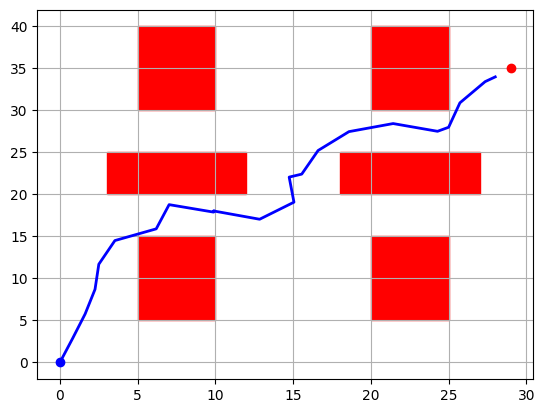

Generation: 54
Fitness: 0.056419773241093756


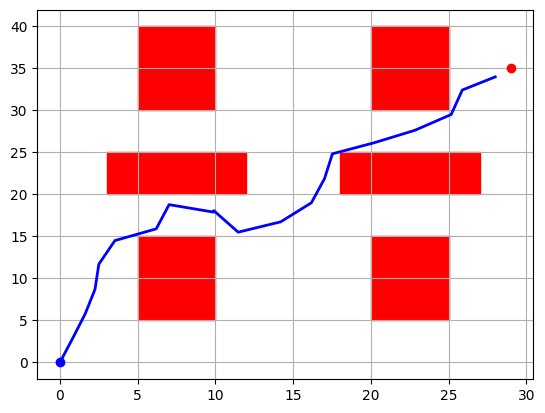

Generation: 55
Fitness: 0.056088883905301014


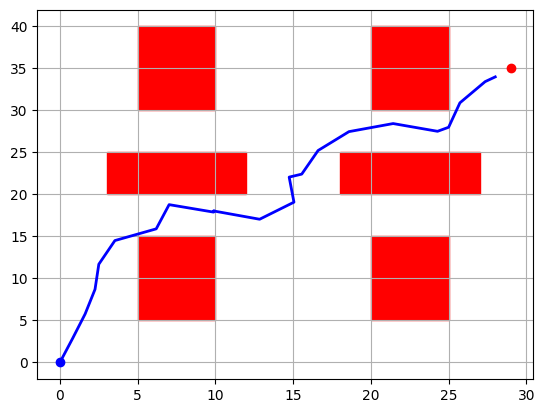

Generation: 56
Fitness: 0.056419773241093756


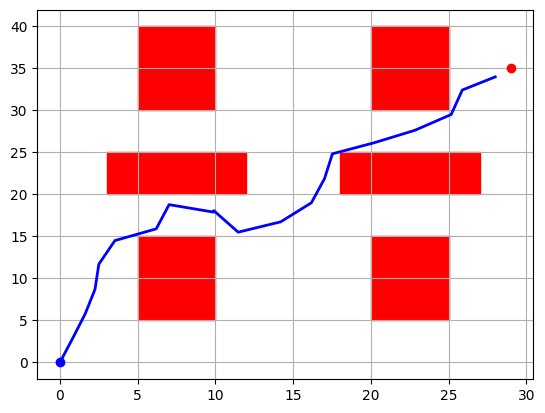

Generation: 57
Fitness: 0.056088883905301014


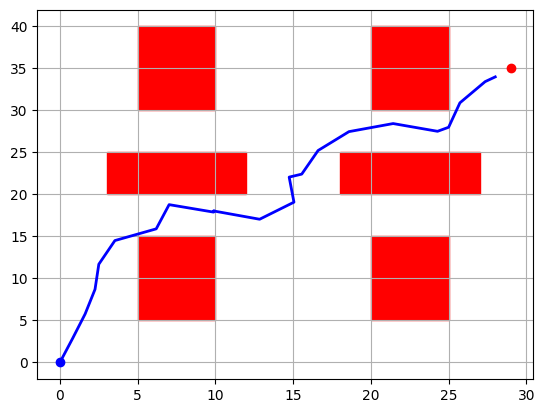

Generation: 58
Fitness: 0.056419773241093756


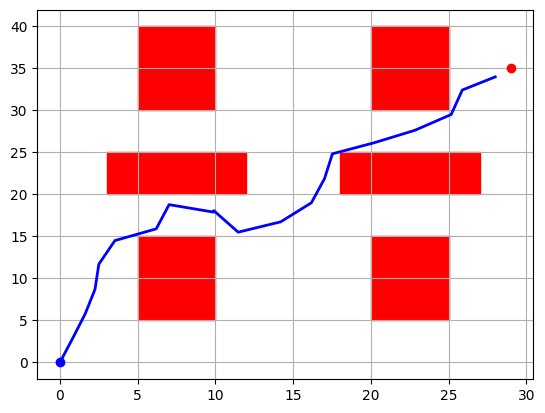

Generation: 59
Fitness: 0.056088883905301014


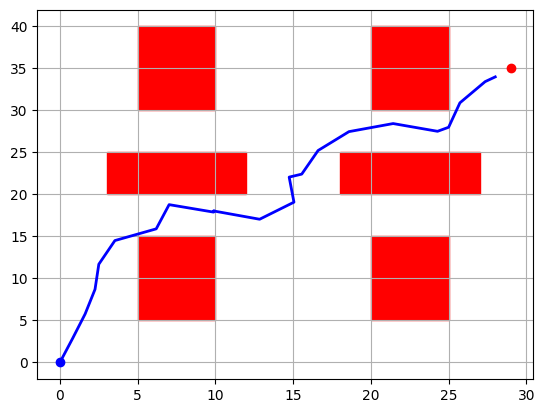

Generation: 60
Fitness: 0.056419773241093756


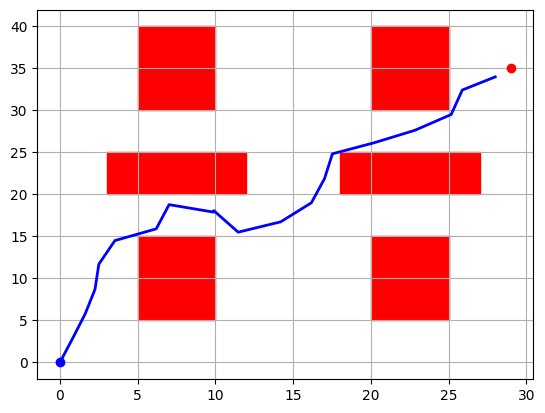

Generation: 61
Fitness: 0.056088883905301014


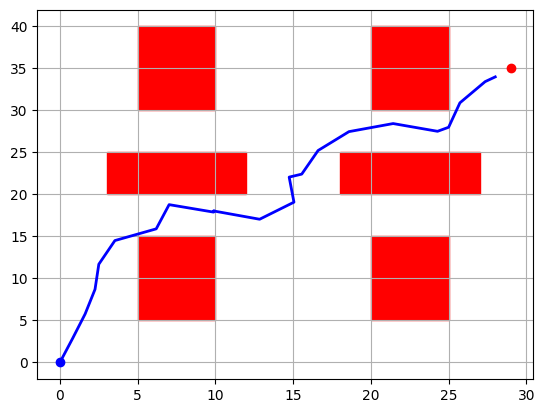

Generation: 62
Fitness: 0.056419773241093756


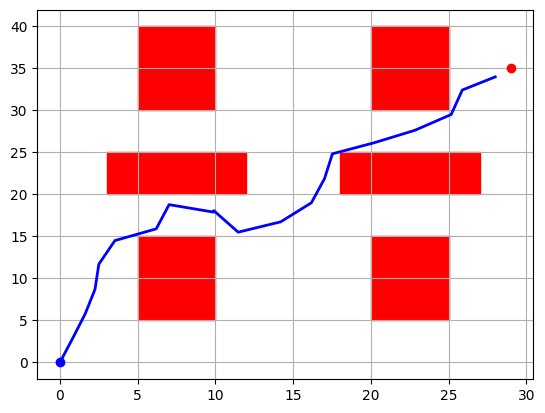

Generation: 63
Fitness: 0.056088883905301014


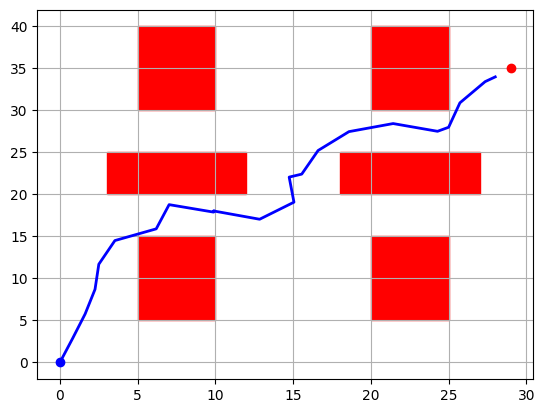

Generation: 64
Fitness: 0.056419773241093756


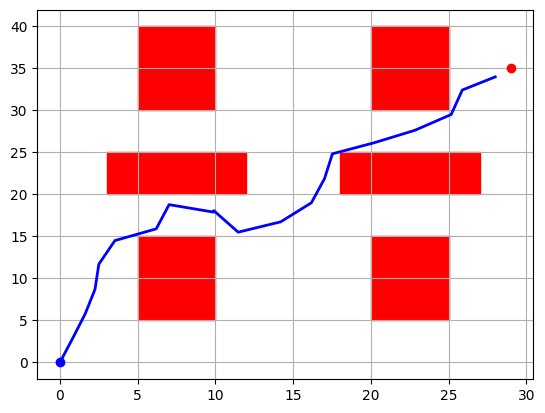

Generation: 65
Fitness: 0.056088883905301014


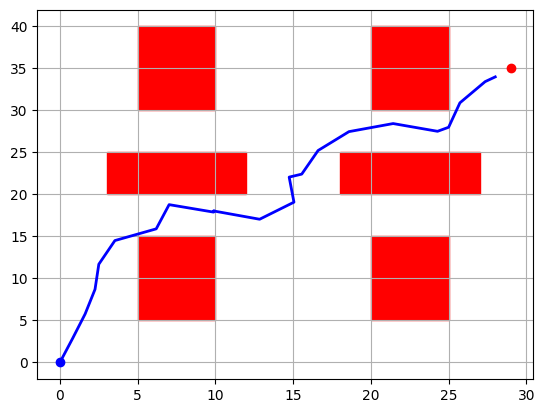

Generation: 66
Fitness: 0.056419773241093756


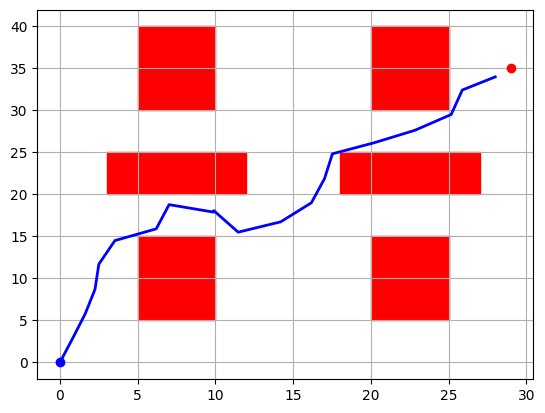

Generation: 67
Fitness: 0.056088883905301014


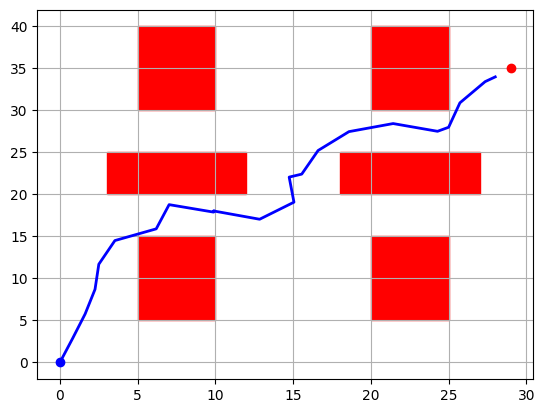

Generation: 68
Fitness: 0.056419773241093756


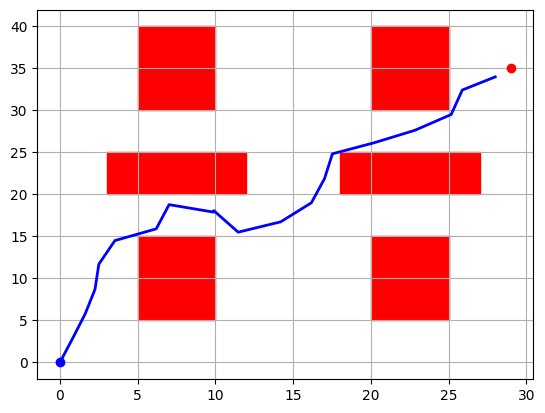

Generation: 69
Fitness: 0.056088883905301014


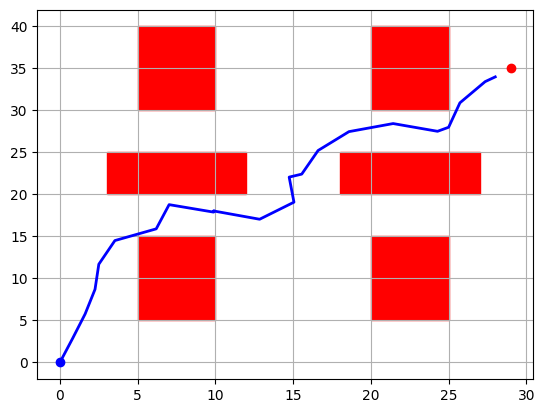

Generation: 70
Fitness: 0.056419773241093756


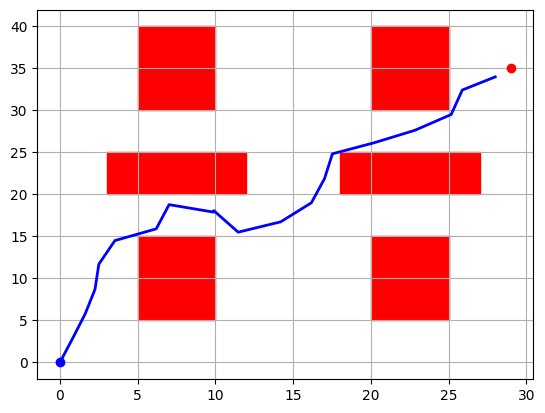

Generation: 71
Fitness: 0.056088883905301014


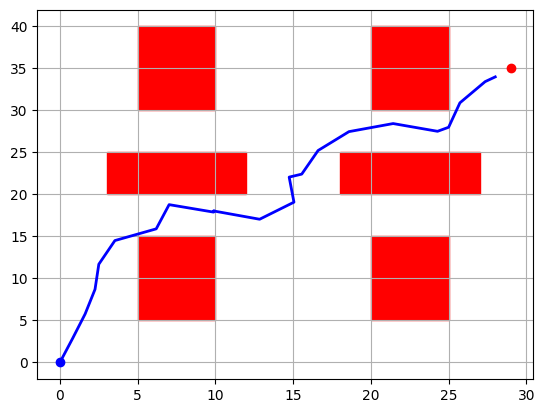

Generation: 72
Fitness: 0.056419773241093756


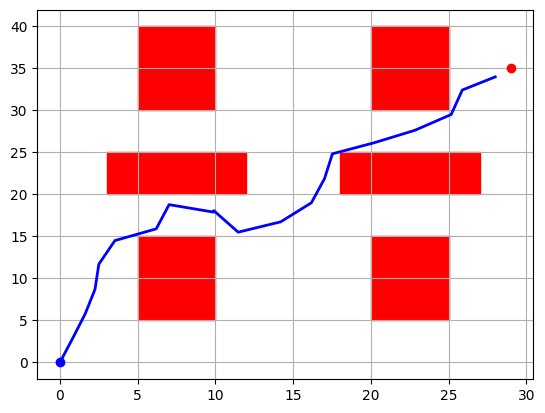

Generation: 73
Fitness: 0.056088883905301014


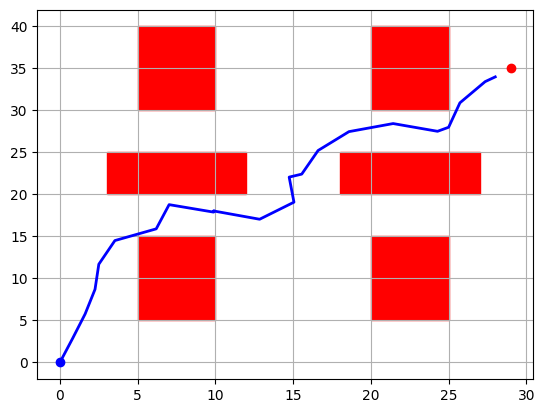

Generation: 74
Fitness: 0.056419773241093756


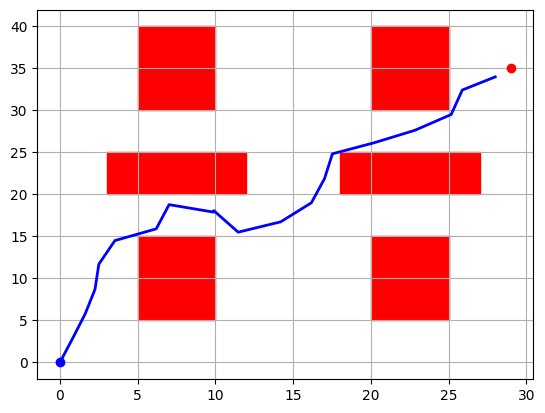

Generation: 75
Fitness: 0.056088883905301014


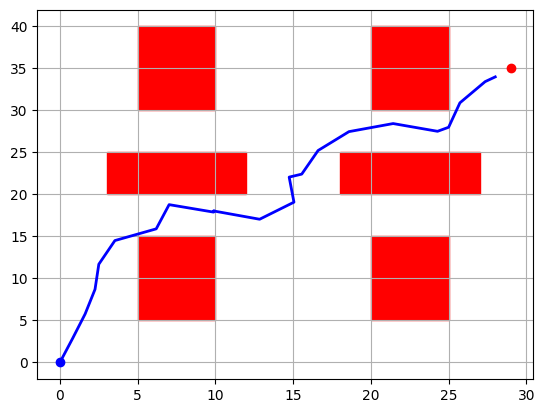

Generation: 76
Fitness: 0.056419773241093756


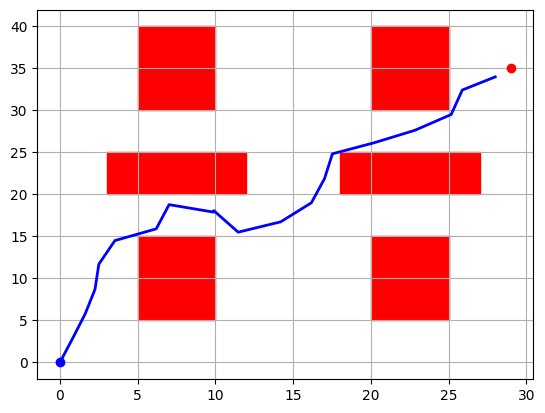

Generation: 77
Fitness: 0.056088883905301014


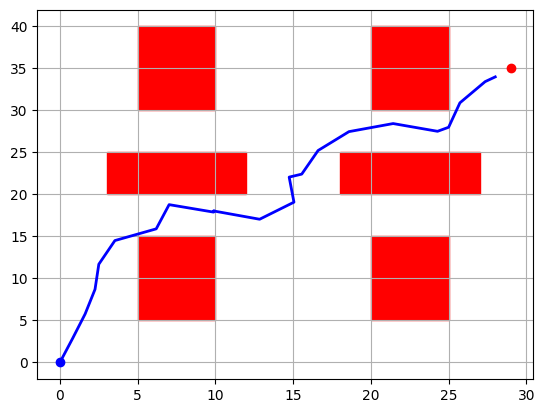

Generation: 78
Fitness: 0.056419773241093756


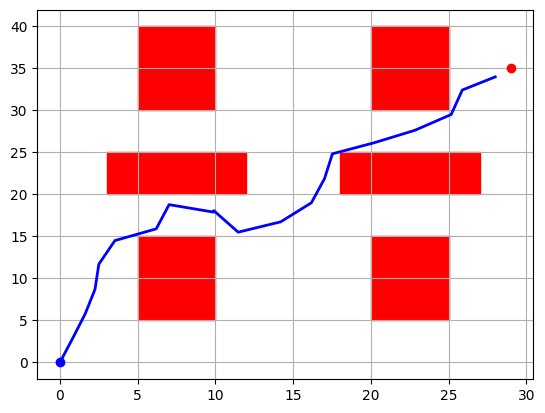

Generation: 79
Fitness: 0.056088883905301014


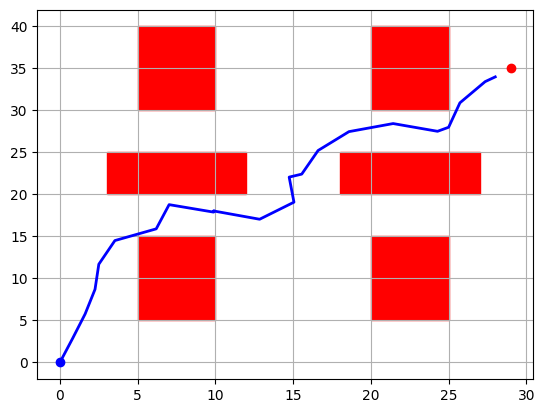

Generation: 80
Fitness: 0.056419773241093756


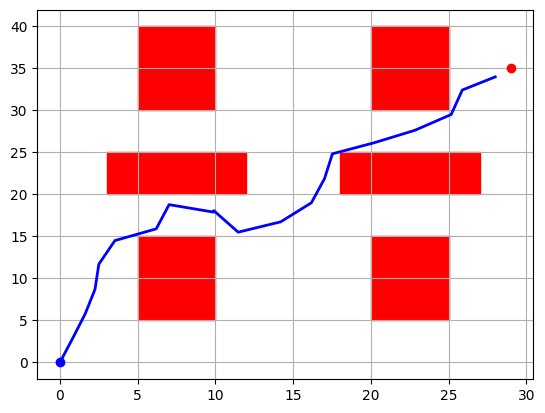

Generation: 81
Fitness: 0.056088883905301014


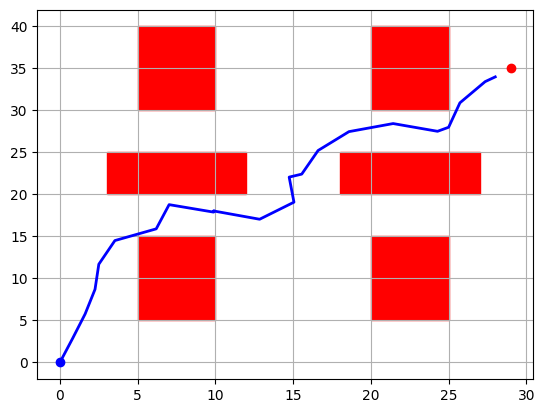

Generation: 82
Fitness: 0.056419773241093756


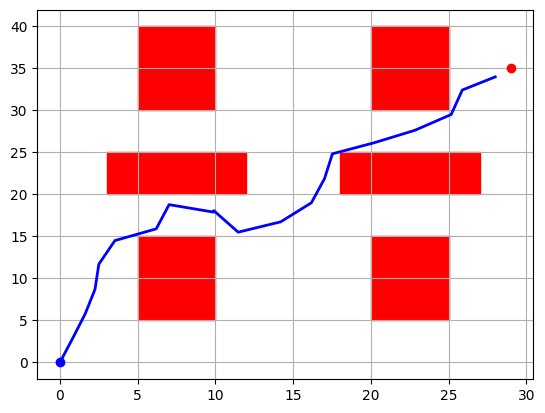

Generation: 83
Fitness: 0.056088883905301014


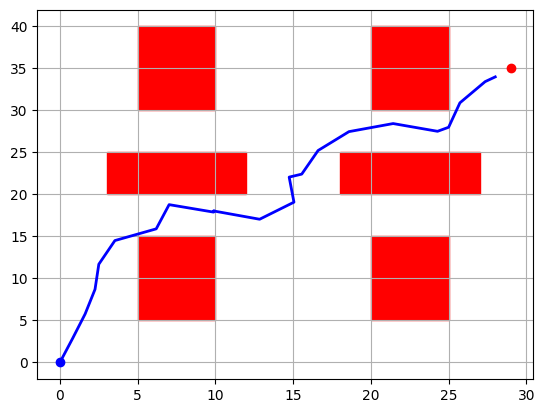

Generation: 84
Fitness: 0.056419773241093756


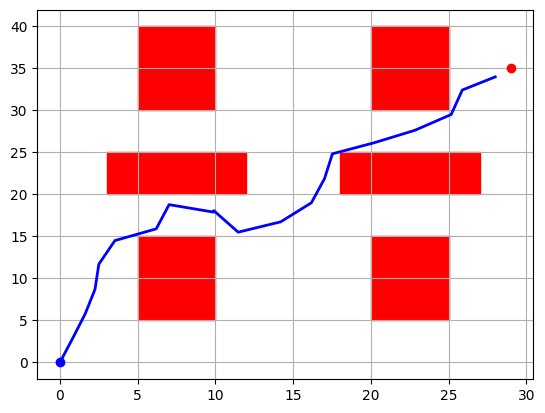

Generation: 85
Fitness: 0.056088883905301014


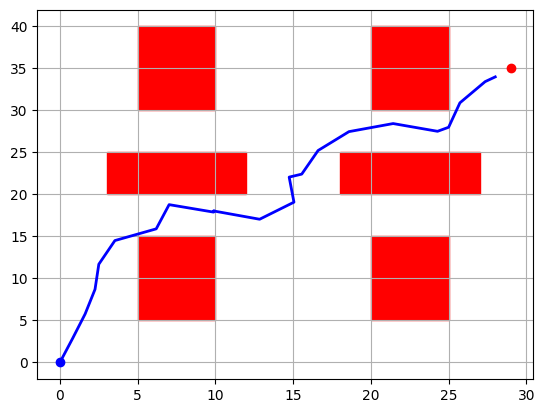

Generation: 86
Fitness: 0.056419773241093756


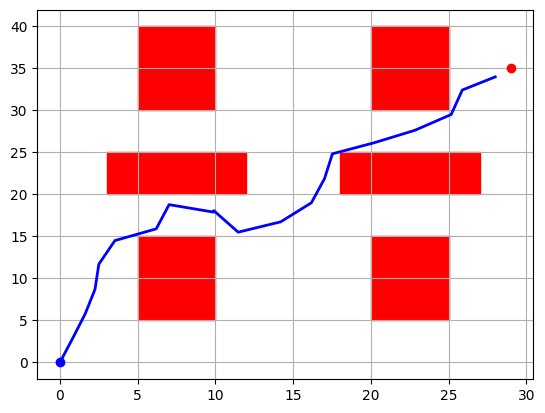

Generation: 87
Fitness: 0.056088883905301014


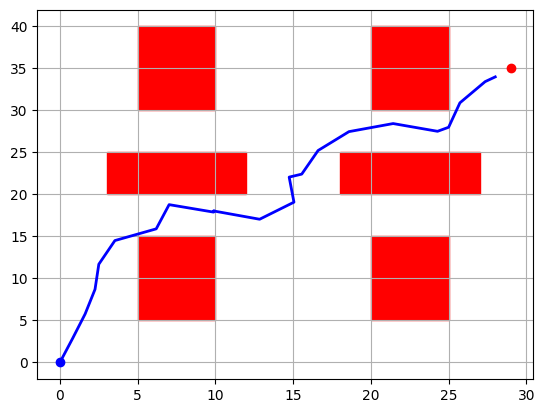

Generation: 88
Fitness: 0.056419773241093756


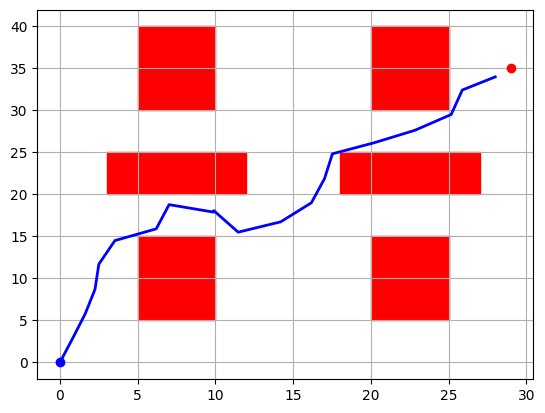

Generation: 89
Fitness: 0.056088883905301014


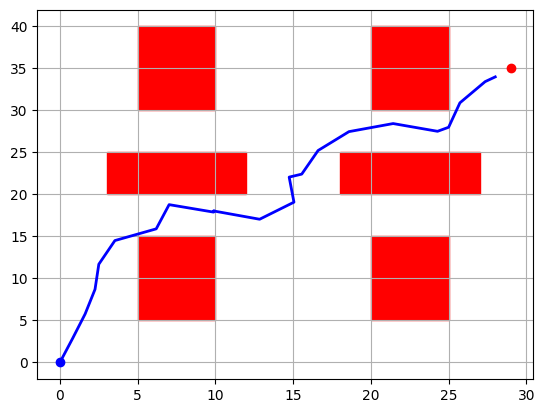

Generation: 90
Fitness: 0.056419773241093756


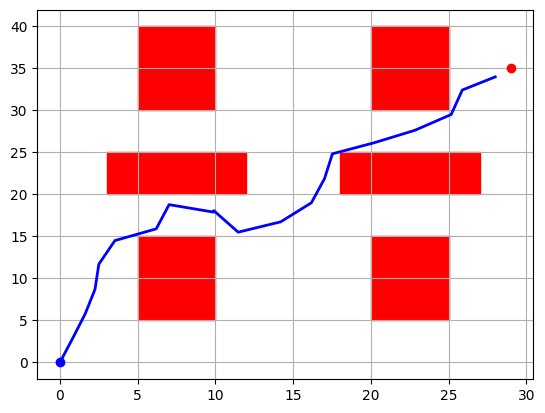

Generation: 91
Fitness: 0.056088883905301014


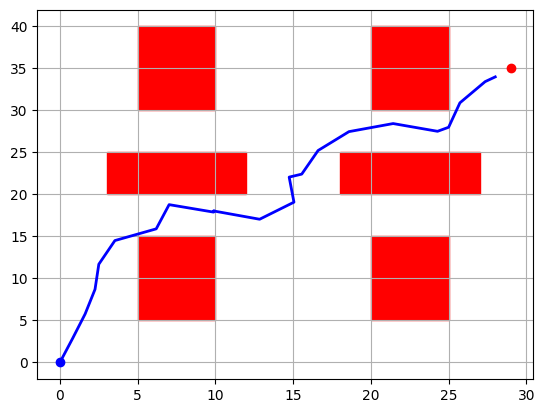

Generation: 92
Fitness: 0.056419773241093756


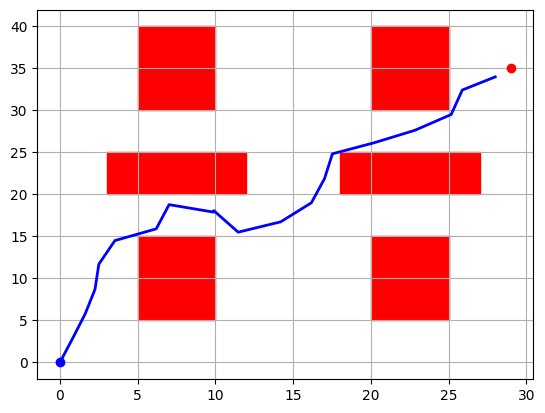

Generation: 93
Fitness: 0.056088883905301014


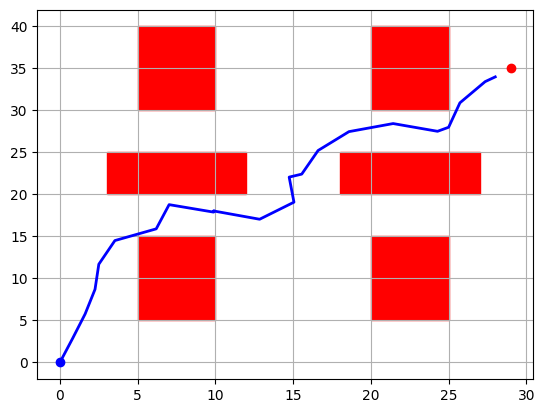

Generation: 94
Fitness: 0.056419773241093756


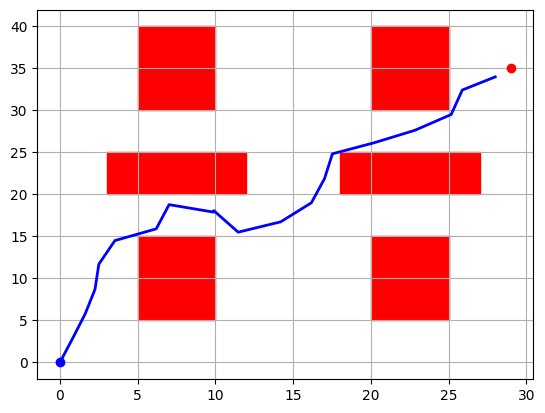

Generation: 95
Fitness: 0.056088883905301014


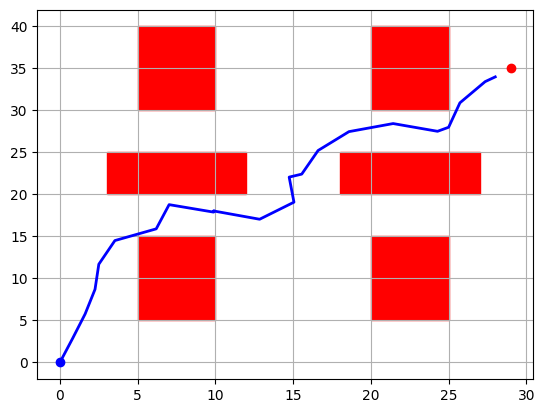

Generation: 96
Fitness: 0.056419773241093756


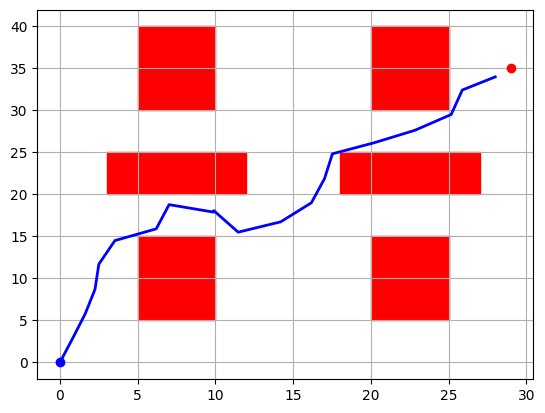

Generation: 97
Fitness: 0.056088883905301014


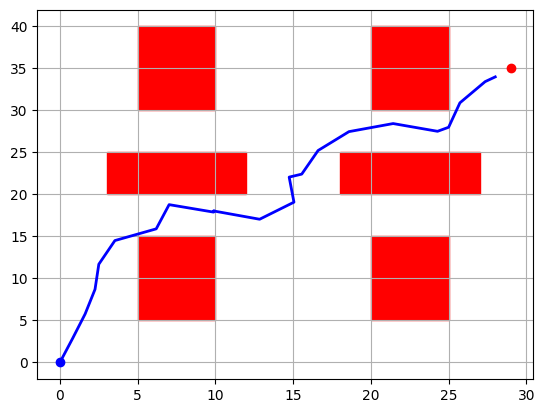

Generation: 98
Fitness: 0.056419773241093756


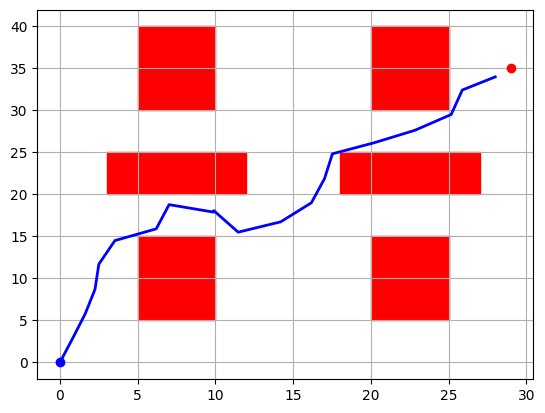

Generation: 99
Fitness: 0.056088883905301014


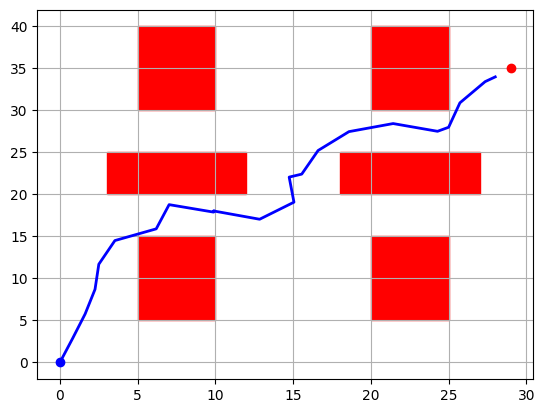

Generation: 100
Fitness: 0.056419773241093756


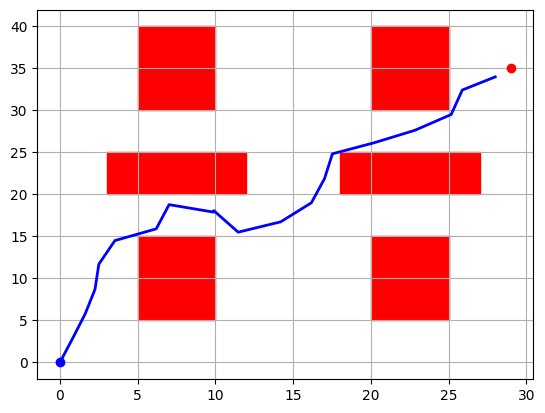

In [400]:
for gen in range (1,101):
  print(f"Generation: {gen}")
  if population:
    fitness = calcualte_fitness_of_population(population)
    # fitness, population = elimination(fitness, population)
    best_fitness = plot_best_solution(fitness=fitness, population=population, plot_graph=True)
    P1, P2 = best_selection(fitness, population)
    # P1, P2 = selection(fitness, population)
    # best_p1 = P1[0]
    # best_p2 = P2[0]
    # population.append(best_p1)
    # population.append(best_p2)
    for i in range(0,len(P1)):
      try:
        offspring1 , offspring2 = crossoverpt(P1[i], P2[i])
        population.append(offspring1)
        population.append(offspring2)
      except:
        pass
        # print(f"Failed for parent set {i}")
        # plot(path=P1[i])
        # plot(path=P2[i])
  else:
    print(f"Termination at generation: {gen}")

In [401]:
def fitness_function(path):
    coordinates = path
    w1 = 3
    w2 = 1
    euc_dist = 0
    angle_sum = 0
    for i in range(len(coordinates)-1):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i+1]
        dist_ = math.sqrt((x2-x1)**2 +(y2-y1)**2)
        euc_dist += dist_
        if i != len(coordinates)-2:
          x3, y3 = coordinates[i+2]
          heading1 = math.degrees(math.atan2((y2-y1),(x2-x1)))
          heading2 = math.degrees(math.atan2((y3-y2),(x3-x2)))
          if heading1 < 0:
            heading1 = 360 + heading1
          if heading2 < 0:
            heading2 = 360 + heading2
          angle = abs(heading2-heading1)
          angle_sum += angle

    F = w1*(1/(euc_dist)+ w2*(1/angle_sum))
    return euc_dist, F

In [402]:
import matplotlib.pyplot as plt

def plot_path(path):
    """
    Plot the path along with waypoints.
    """
    x_values = [point[0] for point in path]
    y_values = [point[1] for point in path]

    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, marker='o', linestyle='-')
    plt.title('Sample Path')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Distance: 6.36067467586918
Fitness: 0.4835734251546645


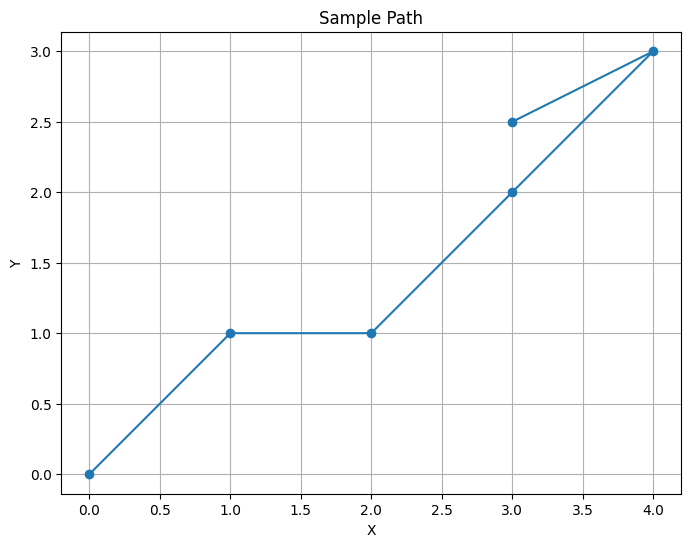

Distance: 6.242640687119285
Fitness: 0.5027880837477834


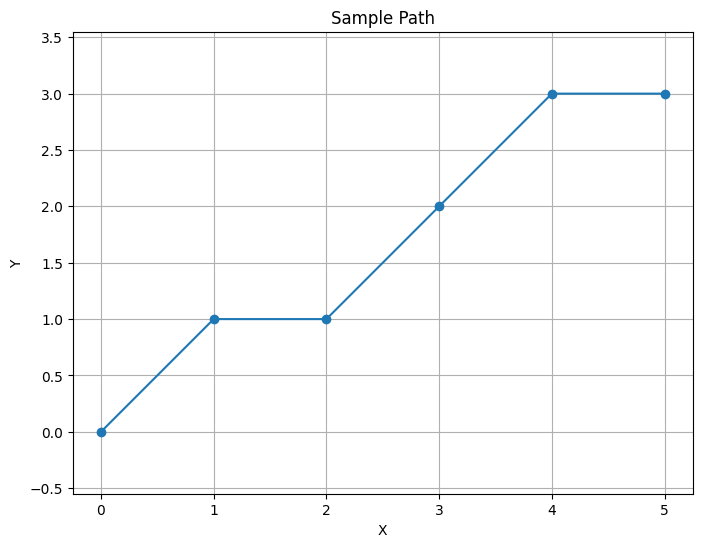

Distance: 6.36067467586918
Fitness: 0.48676638485701834


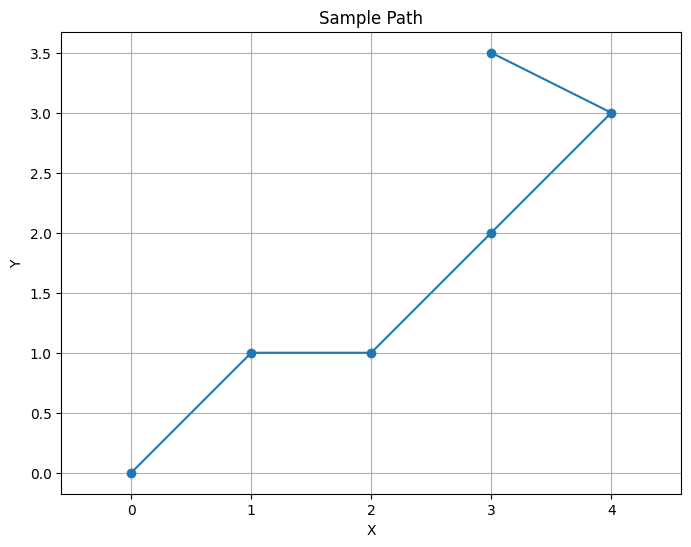

In [403]:
# Example usage:
path = [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (3, 2.5)]
dist, fitness = fitness_function(path)
print("Distance:", dist)
print("Fitness:", fitness)
plot_path(path)

path = [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (5, 3)]
dist, fitness = fitness_function(path)
print("Distance:", dist)
print("Fitness:", fitness)
plot_path(path)

path = [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (3, 3.5)]
dist, fitness = fitness_function(path)
print("Distance:", dist)
print("Fitness:", fitness)
plot_path(path)

In [404]:
# fitness, population = elimination(fitness, population)

In [405]:
# plot(path=P1[0])
# plot(path=P2[0])
# plot(path=offspring1)
# plot(path=offspring2)